# Random Number Generation

This notebook is an introduction to a somewhat tangential and perhaps advanced topic: How to generate random numbers. Many of you have probably used libraries like `random` or `np.random` before to quickly generate a random number. But what are they doing underneath the hood? While you may never in practice write your own random number generators from scratch, if for anything, knowing something about how to do so gives you a deeper understanding of the data sciences, and is a useful skill to know for data science interviews, where variants on such questions are often asked.

<!--
## Why Care About Randomness?
Randomness is an essential aspect of machine learning and data science. For one thing, the theoretical foundations of statistics and machine learning are based on the theory of probability, the formal study of randomness. Many machine learning algorithms are based on probability models. For example, many supervised algorithms try to learn a discriminative probability function of the form $p(y|x)$. This is not the same thing as learning a deterministic function like $y=f(x)$. Why? Because of randomness. In many ways, machine learning itself is really just about making automated predictions under uncertainty.

A deterministic function like $y=f(x)$ says that for each fixed $x$, you're *guaranteed* that the output will be $y$. A probability function like $p(y|x)$ allows for the possibility that a fixed $x$ might output a different $y$ each time the function is called. One example of such a probability function might look simply like $y = f(x) + \text{noise}$, which is just the deterministic function above with a little random noise added in. But what is random noise, and how do you create it in your code?

Asking "what is noise" intimately ties into the question of "what is probability", and is perhaps best answered by a study of probability theory. While I'll try my best to minimize how much you need to know about probability theory in this tutorial, it would at the minimum be a good idea if you're familiar with the notion of probability distributions, particularly the common ones (uniform, normal, binomial, etc), as well as common statistics like mean and variance.

Why should we care about noise? Why not just make all our models deterministic? A few reasons. One big reason is measurement error. We can't guarantee that our data was collected and labeled 100% correctly (in fact, poor data quality is one of if not the most common cause of ML systems performing poorly in production). Imagine you were trying to do regression and your training set consisted of human-collected $(x,y)$ pairs that look something like this:

| x       | y |
|---------|---|
| 1.1     | 1.001 |
| 2.001   | 1.9 |
| 2.99    | 3.0 |
| 4.00001 | 3.99 |
| 5.0     | 5.0001 |

It may at least cross your mind looking at this table that if you were able to round the values then you'd have a nice clean line $y=x$. While it is of course *possible* that the decimal parts are real, it does seem kind of unlikely. It seems much more likely that at least some of the decimal part is due to measurement error. Were you to assume no random noise and just blindly fit a deterministic model to this data you'd almost certainly generalize poorly to new data. You'd be *overfitting*. It would be far more sensible to fit a probability model $y = x + \varepsilon$, where $\varepsilon$ is a stand-in for random noise due to measurement error. You could imagine simulating this measurement process by *sampling* the *random variable* $\varepsilon$ from a probability distribution (e.g. a standard normal), and then adding it to $x$ to get the target value $y$. Taking randomness into account thus allows ML models to learn *robust* (i.e. noise-tolerant) functions to estimate the data.

Another reason randomness is important in ML is that it can be used to improve model performance. For example, here are a few interesting observations about deep neural networks:
- They train better when their weights are randomly initialized a certain way. Bad initializations can result in very poor models.
- They generalize better when their weights are stored in a reduced precision floating point (which is a way of adding randomness to the weights themselves). A common trend now is to use *half precision* floating point for the weights. Seems against the grain that more precise is better, right?
- They train better when neurons in each layer are randomly zeroed out during each iteration. This is called dropout.
-->

Now, let's talk about how one might go about generating random numbers from scratch in python. It turns out this is a subtle topic, because computers are deterministic devices (more or less). Programs follow a well-defined sequence of instructions, which is a deterministic process, so how can one generate anything approximating random behavior from a deterministic process? It turns out you can, kind of. We call the "random" numbers generated in such a way *pseudo-random*, because they're not really random (they can't be), but they none the less behave as random in most practical respects.

Let's see how this can be done. The only libraries we allow ourselves to use here are `numpy` (but not `np.random`) , `pandas` (mainly for visualization), and `matplotlib`, except for some special util functions later on. Let's start by loading these libraries in as usual.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

seed = 123
np.random.seed(seed)

In [2]:
def summarize(sample, title=None):
    df = pd.Series(samples)
    print(df.describe())
    plt.hist(sample);
    plt.title(title)
    plt.show()

## Sampling From a Standard Uniform Distribution (rand)

I've mentioned that random number generators are in fact not random, but deterministic, yet behave as random for many practical purposes. How do we achieve this? The trick is to define a function that generates outputs in a sequence that *look like* they have no discernible relationship to each other, while at the same time the (shuffled) sequence looks like it comes from some distribution. It will work as follows, we specify an initial value, called the *seed*, denoted $x_0$. Suppose we'd like to generate $n$ pseudo-random numbers $x_1, x_2, \cdots, x_n$. For a suitable function $f$, we can do this via a recursion like this:
$$x_1 = f(x_0)$$
$$x_2 = f(x_1)$$
$$x_3 = f(x_2)$$
$$ \dots $$
$$x_n = f(x_{n-1}).$$

The first goal will be to define a function $f$ that can generate a sequence of numbers $x_1, x_2, \cdots, x_n$ that *look like* they were uniformly sampled from the continuous range $[0,1]$. That is, each sample is equally likely to take on any continuous value between 0 and 1, but nothing else. One simple, though non-intuitive type of function that can do this is the *linear congruence generator* (LCG). An LCG function has the form
$$f(x) = (ax + c) \mod m,$$
where $a,c,m$ are suitably large integer constants fixed ahead of time. 

Let's see what a function like this outputs on a simple example, where $a=5, c=3, m=8$, and seed is $x_0=123$. Does it look random to you? Does the set look uniformly sampled from $[0,1]$?

In [3]:
a = 5
c = 3
m = 8
f = lambda x: (a * x + c) % m

In [4]:
x = 123
for i in range(10):
    x = f(x)
    print(x)

2
5
4
7
6
1
0
3
2
5


The set does look kind of random. Could you predict the sequence without knowing $a, c, m, x_0$? It's obvious each number isn't between 0 and 1, yet, but we can fix that pretty easily. Does the sequence look uniformly random? Hard to say. Let's sample some more numbers and plot their histogram. 

Looks pretty uniform to me. Notice the values though. It turns out that this function only samples (pseudo) uniformly between 0 and 7, i.e. in the integer range $0, \cdots, m-1$. This suggests two observations: 1) we can scale samples to be between 0 and 1 by dividing them by $m$, and 2) the size of $m$ controls the granularity of how fine we can sample (higher $m$ means finer sampling in $[0,1]$).

Remark: It's actually very important that $a, c, m$ be chosen a certain way. You can't just pick any values or you'll get things like repeating sequences. See [here](https://en.wikipedia.org/wiki/Linear_congruential_generator) for details.

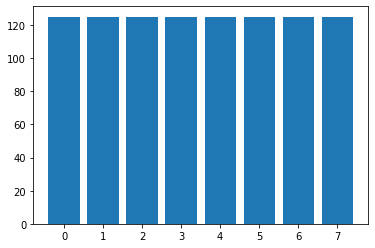

In [5]:
samples = []
x = 123
for i in range(1000):
    x = f(x)
    samples.append(x)

# plotting a nicer histogram than plt.hist would give
u, counts = np.unique(samples, return_counts=True);
plt.bar(np.arange(len(u)), counts);
plt.xticks(np.arange(len(u)), u);

In practice, it's a good idea to choose $a, c, m$ to all be large integers. A standard choice (though by no means the only one) is to take $a=1664525, c=1013904223, m=2^{31}$. Let's sample again with these constants, and then rescale by $m$ so the samples are between 0 and 1. There's certainly some visible variation, but on the whole the histogram looks rectangular, which is what you'd expect from a standard uniform sample.

We can sanity check the generator some more by verifying the statistics look as expected. For a standard uniform, we'd expect samples to have

\begin{equation}
\begin{aligned}
\text{min}&=0, \\
\text{max}&=1, \\
\text{mean}&= \frac{1}{2} = 0.5, \\
\text{std dev}&=\sqrt{\frac{1}{12}} \approx 0.289.
\end{aligned}
\end{equation}

Notice also that by taking more samples that the samples start to appear more uniform. In the first example below, I generate 1000 samples. In that case the histogram looks kind of uniform, but a bit bumpy. In the second example, I generate 10,000 samples. In that case the histogram looks significantly less bumpy, and the statistic estimates are 1-2 orders of magnitude closer to the true values above for a standard uniform.

count    1000.000000
mean        0.508971
std         0.291887
min         0.001314
25%         0.244950
50%         0.517116
75%         0.775725
max         0.999371
dtype: float64


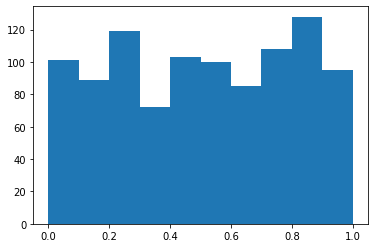

In [6]:
a = 1664525
c = 1013904223
m = 2**31
f = lambda x: (a * x + c) % m

samples = []
x = 123
size = 1000
for i in range(size):
    x = f(x)
    u = x / m
    samples.append(u)

summarize(samples)

count    10000.000000
mean         0.500245
std          0.289041
min          0.000142
25%          0.249011
50%          0.500668
75%          0.753247
max          0.999677
dtype: float64


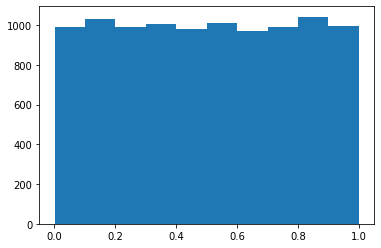

In [7]:
samples = []
x = 123
size = 10000
for i in range(size):
    x = f(x)
    u = x / m
    samples.append(u)

summarize(samples)

We finally have everything we need to implement the most fundamental random number generator of all, the `rand` function. But first, a brief word on generating seeds.

There are two common situations when it comes to seeds. In one case, the usual case in data science situations, the seed should always be fixed and pre-specified before hand. This allows for seemingly random programs to be reproduced by someone else, which is useful for verifying that the program is running as intended. In data science, this (sort of) allows one to be able to train a new model that reproduces the behavior of a previously trained model. As a rule of thumb, if you're trying to do *reproducible research*, you should always fix and specify your seed in advance.

In the other case, fixing and publishing the seed is bad, as knowledge of the seed takes what *should* be a random process and makes it completely deterministic. If one knows the seed, the generator used, and how many samples have been sampled so far, one can in principle predict with certainty what the next sample will be. This is dangerous in certain fields like cryptography and security, where it's essential that one not easily be able to deconstruct a random function (as it might result in a very unfortunate hacking situation). 

In the latter case, it's essential that the seed be as hard as possible for a third party to guess. One often done way to generate hard-to-guess seeds is by choosing them based on the system clock the program is running on. For example, suppose the system clock reads `29344.743828348`. One can generate a seed by taking the sequence after the decimal point as an integer value for the seed, so in this case we'd have `seed = 743828348`. System clock seeds are hard to guess because it's hard for a human to figure out the *exact* time the seed was generated at the millisecond level. A simple such a seed generator is shown below as `get_seed`.

In [8]:
def get_seed():
    """Generates random seed using decimal part of system clock"""
    import time
    t = time.perf_counter()
    return int((t % 1) * 1e16)

for i in range(10):
    print(get_seed())

6929731410928071
6933804550208151
6934164632111788
6934454198926687
6934720599092543
6934989900328219
6935265129432082
6935527832247317
6935799731872976
6936061270534992


With this aside on seeds addressed, we return to the `rand` function, which is implemented below using the above linear congruence generator. The job of `rand` is to output a standard uniform number as described above. We will implement `rand` such that it takes constants `a, c, m`, a seed `seed`, and a size `size` specifying how many numbers to sample. To verify it works as intended we use `rand` to generate 1000 samples and show their summary statistics. To promote reproducibility, I fix all the seeds below in advance to the value defined at the beginning of the notebook.

count    1000.000000
mean        0.508486
std         0.288553
min         0.000689
25%         0.269031
50%         0.509139
75%         0.761345
max         0.995772
dtype: float64


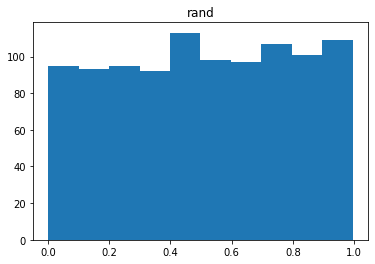

In [55]:
def rand(a=1664525, c=1013904223, m=2**32, size=1, seed=None):
    """Generates Uniform(0,1) samples using linear congruence generator"""
    f = lambda x: (a * x + c) % m
    x = get_seed() if seed is None else seed
    u = []
    for i in range(size):
        x = f(x)
        u.append(x / m)
    return np.array(u)

size = 1000
samples = rand(size=size, seed=seed)
summarize(samples, title=f'rand')

## Sampling From Other Probability Distributions

Armed with `rand`, it turns out we can generate numbers from pretty much any probability distribution we want just by doing transformations on standard uniform samples. There are a few common ways to generate new distributions from a uniform random sample: simple probability transformations, inverse transform sampling, and rejection sampling.

Simple probability transformations involve applying some kind of transformation to samples from the standard uniform to turn them into samples from a different desired distribution. Such transformations might involve translation, scaling, or simple operations like applying a common function (exp, log, power, trig, etc). We'll see a few examples of such techniques below.

[Inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) works by making use of the following simple theorem from probability: If a [random variable](https://en.wikipedia.org/wiki/Continuous_random_variable) $X$ has a [cdf](https://en.wikipedia.org/wiki/Cumulative_distribution_function) $F$, then the random variable $U=F(X)$ has a standard uniform distribution. We can make use of the inverse of this theorem. Namely, if $U$ is standard uniform, then $F^{-1}(U)$ has the same distribution as $X$. This means we can use a uniform sample to generate samples with the intended distribution by applying that distribution's inverse cdf to it, if we know it.

[Rejection Sampling](https://en.wikipedia.org/wiki/Rejection_sampling) is a more advanced technique that involves sampling from an easier "proposal" distribution, and then keep only samples that satisfy some acceptance criterion that relates the proposal to the original distribution. Such an approach falls under the general umbrella of [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (MCMC) methods. Perhaps the most powerful algorithm for doing rejection sampling is the [Metropolis-Hastings Algorithm](https://en.wikipedia.org/wiki/Metropolis_algorithm), which allows one to sample from arbitrary distributions (even if you don't know its functional form). I won't touch on these techniques here, but may come back to it later.

### Uniform Distribution

Perhaps the simplest distribution we can create from `rand` is the (arbitrary) uniform distribution. A number sampled from `uniform` takes parameters $low$ and $high$, and should return any continuous number in the interval $[low, high]$ with equal probability. It's just a rescaling of the standard uniform distribution. We can easily transform a standard uniform sample $\text{Uniform}(0,1)$ to a $\text{Uniform}(low, high)$ sample by applying the following rescaling:

$$\text{Uniform}(low, high) = (high - low)\text{Uniform}(0,1)+low.$$

This is implemented below. The expected statistics for this distribution are given below. How well do these values match the ones in the example below?

\begin{equation}
\begin{aligned}
\text{min}&=low, \\
\text{max}&=high, \\
\text{mean}&= \frac{low + high}{2}, \\
\text{std dev}&=\sqrt{\frac{(high-low)^2}{12}}.
\end{aligned}
\end{equation}

count    1000.000000
mean        5.084856
std         2.885532
min         0.006890
25%         2.690312
50%         5.091392
75%         7.613449
max         9.957720
dtype: float64


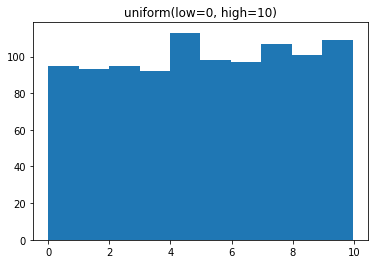

In [71]:
def uniform(low=0, high=1, size=1, seed=None):
    """Generates Uniform(low, high) samples"""
    return ((high - low) * rand(seed=seed, size=size) + low)

size = 1000
samples = uniform(size=size, seed=seed, low=0, high=10)
summarize(samples, title=f'uniform(low=0, high=10)')

### Discrete Uniform Distribution (randint)

The next distribution we'll discuss is the discrete uniform distribution, which is like the uniform distribution but only allowed allowed to take on integer values in the interval. Namely, given parameters $low$ and $high$, a $\text{DiscreteUniform}(low, high)$ sample can take on any integer value between $low$ and $high$ with equal probability.

The discrete uniform implementation is frequently called `randint`. It works simply by sampling from `uniform(low, high)` and rounding each number down to the nearest integer. Note this means in particular that `low` is inclusive while `high` is exclusive, so values take a range `low, ..., high-1`.

The expected statistics for $\text{DiscreteUniform}(low, high)$ with support $[low,high)$ are below. How well do these values match the ones in the example below?

\begin{equation}
\begin{aligned}
\text{min}&=low, \\
\text{max}&=high-1, \\
\text{mean}&= \frac{low + high - 1}{2}, \\
\text{std dev}&=\sqrt{\frac{(high-low)^2-1}{12}}.
\end{aligned}
\end{equation}

count    1000.000000
mean        2.056000
std         1.404577
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
dtype: float64


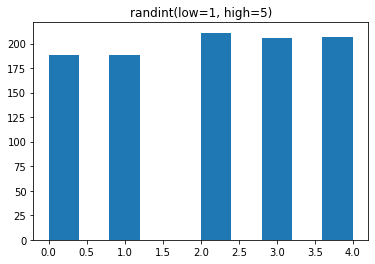

In [72]:
def randint(low=0, high=2, size=1, seed=None):
    """Generates DiscreteUniform(low, high) samples, i.e. random ints [low, high)"""
    u = uniform(low=low, high=high, size=size, seed=seed)
    return np.floor(u).astype(int)

size = 1000
samples = randint(size=size, seed=seed, low=0, high=5)
summarize(samples, title=f'randint(low=1, high=5)')

### Sampling an Array (choice)

Before continuing with the other distributions let's make a quick detour and talk about randomly sampling from an arbitrary array. When doing so it's necessary to distinguish between randomly sampling *with replacement* (WR) and randomly sampling *without replacement* (WOR). When sampling WR, we imagine putting that value back into the array so we can sample it again later if we wish with an equal probability. Whereas when sampling WOR, we imagine holding the value out so it can't be sampled again later (which means among other things that sampling can't be uniform since the probabilities change as a result of removing elements from the array).

In the case of sampling from an array we usually mean sampling WR (though not always). The implementation of sampling from an array is called `choice` in python. Below is an implementation of `choice` to allow sampling WR from an arbitrary array. Notice all we have to do is randomly sample the index of the array with `randint`, and then just return the values corresponding to those indexes.

In the sample below, we sample from `choice` `size` times on the string `abracadabra`, and display the counts for each letter and the histogram. Do the frequencies shown appear to match the frequency of the letters as they appear in `abracadabra`? They should.

a    437
b    181
r    171
d    106
c    105
dtype: int64


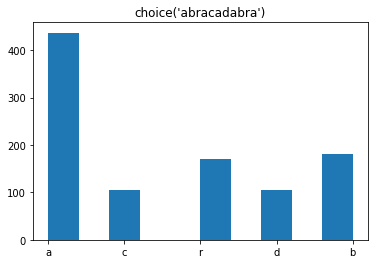

In [52]:
def choice(array, size=1, seed=None):
    """Randomly samples from given array, with replacement"""
    array = np.array(array)
    r = randint(low=0, high=len(array), size=size, seed=seed)
    return array[r]

array = list('abracadabra')

size = 1000
samples = choice(array, size=size, seed=seed)
print(pd.Series(samples).value_counts())
plt.hist(samples);
plt.title(f'choice(\'{"".join(array)}\')');

### Bernoulli Distribution

Returning to distributions, the Bernoulli distribution is a basic distribution that only takes on binary values 0 and 1. Sampling from $\text{Bernoulli}(p)$ returns 1 with probability $p$ or 0 with probability $1-p$. As you probably know, this distribution is frequently used to model real-world binary processes like coin flips, and is the theoretical basis of (binary) logistic regression. Its density is given by

$$p(x) = p^x (1-p)^{1-x}.$$

We can again implement $\text{Bernoulli}(p)$ using `rand`. The idea here is to use $p$ as a threshold to decide whether to round a `rand` number down to 0 or up to 1. This is implemented below as `bernoulli`, which takes a parameter `p` and returns a $\text{Bernoulli}(p)$ sample.

The expected statistics for $\text{Bernoulli}(p)$ are below. How well do these values match the ones in the example below?

\begin{equation}
\begin{aligned}
\text{min}&=0, \\
\text{max}&=1, \\
\text{mean}&= p, \\
\text{std dev}&=\sqrt{p(1-p)}.
\end{aligned}
\end{equation}

count    1000.000000
mean        0.188000
std         0.390908
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
dtype: float64


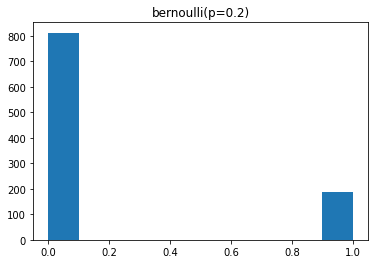

In [56]:
def bernoulli(p=0.5, size=1, seed=None):
    """Generates Bernoulli(p) samples"""
    u = rand(size=size, seed=seed)
    return (u <= p).astype(int)

size = 1000
samples = bernoulli(size=size, seed=seed, p=0.2)
summarize(samples, title=f'bernoulli(p=0.2)')

### Binomial Distribution

As many of you know, the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation) is a model for the number of successful outcomes from $n$ binary (Bernoulli) trials. A $\text{Binomial}(n,p)$ random variable is just a sum of $n$ Bernoulli random variables, and can thus take on integer values between $0$ and $n$. Its density is given by

$$p(x) = {n \choose x} p^x (1-p)^{n-x}.$$

Given the binomial is just a sum of bernoullis, implementation is pretty easy. To create a function `binomial(n, p)`, we basically just call `bernoulli(p)` `n` times and sum the results together to get a single binomial sample. 

One subtlety in the implementation is worth addressing though. It's *very* important to make sure each bernoulli sample be taken with a different seed. If you use the same seed all of the bernoulli samples will end up being the same, which means each sample of `binomial` will be the same number! To get around this, and still keep things reproducible, the easiest thing to do is to increment the seed in each iteration of the loop.

The expected statistics for $\text{Binomial}(n,p)$ are below. How well do these values match the ones in the example below?

\begin{equation}
\begin{aligned}
\text{min}&=0, \\
\text{max}&=n, \\
\text{mean}&= np, \\
\text{std dev}&=\sqrt{np(1-p)}.
\end{aligned}
\end{equation}

Aside: Notice the histogram for this binomial sample looks almost like that of a Gaussian distribution. This is not a coincidence. Turns out $\text{Binomial}(n,p) \approx \mathcal{N}(np, np(1-p))$ under certain regularity conditions. See [here](https://en.wikipedia.org/wiki/De_Moivre%E2%80%93Laplace_theorem) for details.

count    1000.000000
mean        4.929000
std         1.560896
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        10.000000
dtype: float64


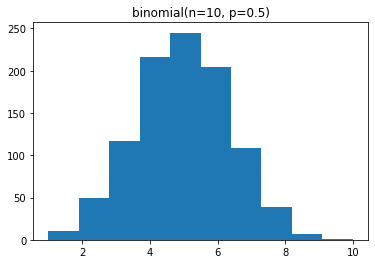

In [58]:
def binomial(n, p=0.5, size=1, seed=None):
    """Generates Binomial(n, p) samples"""
    x = []
    for i in range(size):
        b = bernoulli(p=p, size=n, seed=seed)
        x.append(b.sum())
        seed += 1
    return np.array(x)

size = 1000
samples = binomial(size=size, seed=seed, n=10, p=0.5)
summarize(samples, title=f'binomial(n=10, p=0.5)')

### Poisson Distribution

The [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) is used to model counting processes. $\text{Poisson}(\lambda)$ takes a parameter value $\lambda > 0$, and can take on any positive integer value, and its density tends to have a "hump" character, where it peaks around the parameter value $\lambda$. In math, its density is given by

$$p(x) = \frac{\lambda^x e^{-\lambda}}{x!}.$$

Implementing a sampler for $\text{Poisson}(\lambda)$ is a bit different. Here I choose to implement `poisson` using a [sampling algorithm](https://en.wikipedia.org/wiki/Poisson_distribution#Generating_Poisson-distributed_random_variables) created by Donald Knuth. The idea here is to make use of a fact about Poisson distributions that states the time between new events is exponentially distributed. (More explanation to be added later.)

Note: This algorithm only works well when `lambda_` is not too large (a rule of thumb is under `lambda_=30`). This is due to the fact that the inner loop depends on `np.exp(-lambda_)` taking on a non-zero value, which is impractical when `lambda_` is large due to numerical underflow. For larger values of `lambda_` the algorithm should be tweaked. See [here](https://www.johndcook.com/blog/2010/06/14/generating-poisson-random-values/) for an example of how to do this.

The expected statistics for $\text{Poisson}(\lambda)$ are below. How well do these values match the ones in the example below?

\begin{equation}
\begin{aligned}
\text{min}&=0, \\
\text{max}&=\infty, \\
\text{mean}&= \lambda, \\
\text{std dev}&=\sqrt{\lambda}.
\end{aligned}
\end{equation}

count    1000.000000
mean       13.960000
std         4.751734
min         7.000000
25%        10.000000
50%        13.000000
75%        18.000000
max        25.000000
dtype: float64


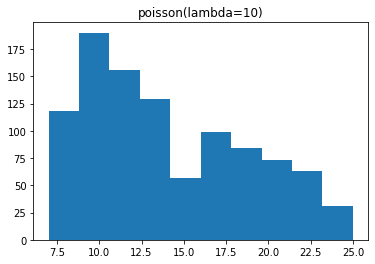

In [59]:
def poisson(lambda_=1, size=1, seed=None):
    """Generates Poisson(lambda) samples using Knuth algorithm"""
    array = []
    L = np.exp(-lambda_)
    for j in range(size):
        x = 0
        p = 1
        while p > L:
            x += 1
            p = p * rand(seed=seed)
        array.append(x - 1)
        seed += 1
    return np.array(array)

size = 1000
samples = poisson(size=size, seed=seed, lambda_=10)
summarize(samples, title=f'poisson(lambda=10)')

### Exponential Distribution

The exponential distribution is often used to model arrival times of processes following a Poisson distribution. Given that it's used to model times, an exponential random variable can take on any positive real value. It's parametrized by a rate parameter $\lambda > 0$ that determines the (inverse) expected arrival time. Its density is given by

$$p(x) = \lambda e^{-\lambda x}.$$

An $\text{Exponential}(\lambda)$ random sample can easily be generated using inverse transform sampling. The CDF of $\text{Exponential}(\lambda)$ is 
$$F(x) = 1 - e^{-\lambda x},$$
which means its inverse CDF is 
$$F^{-1}(u) = -\frac{1}{\lambda} \log(1-u).$$
Thus, we merely have to generate a `rand()` and apply the inverse CDF to it to get an exponential random sample. This is implemented as `exponential` below, and takes in the rate parameter as `lambda_`. I merely sample a uniform sample via `rand()` and apply the above inverse CDF transformation to get an exponential sample.

The expected statistics for $\text{Exponential}(\lambda)$ are below. How well do these values match the ones in the example below?

\begin{equation}
\begin{aligned}
\text{min}&=0, \\
\text{max}&=\infty, \\
\text{mean}&= \frac{1}{\lambda}, \\
\text{std dev}&=\sqrt{\frac{1}{\lambda^2}}.
\end{aligned}
\end{equation}

count    1000.000000
mean        1.004936
std         0.936356
min         0.000689
25%         0.313385
50%         0.711595
75%         1.432740
max         5.466028
dtype: float64


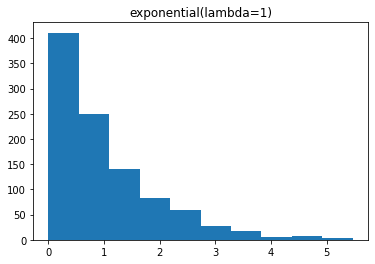

In [60]:
def exponential(lambda_=1, size=1, seed=None):
    """Generates Exp(lambda) samples using Inverse Transform Sampling"""
    u = rand(seed=seed, size=size)
    x = - (1 / lambda_) * np.log(1 - u)
    return x

size = 1000
samples = exponential(size=size, seed=seed, lambda_=1)
summarize(samples, title=f'exponential(lambda=1)')

### Gaussian / Normal Distribution

The Gaussian distribution (aka the Normal distribution) is without a doubt the most important distribution out there. It's used to model all kinds of things: measurement errors, the parameter values in a neural net, the velocities of a gas in a container, approximating other distributions via the central limit theorem, and much more. This distribution takes on the characteristic "bell curve", where a mean value is centered at the top of the bell, and values away from the mean become less and less likely to get sampled. The Gaussian, represented as $\mathcal{N}(\mu, \sigma^2)$, takes two parameters $\mu$ and $\sigma$, each of which can take on any real value. Its density is given by

$$ p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x-\mu)^2}{\sigma^2}}.$$

Generating samples from a Gaussian is most frequently done using the [Box Muller Transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform). The idea is to apply a transformation to 2 uniform random variables $U_1, U_2$:

$$ Z_0 = \sqrt{-2 \log U_1} \cos (2 \pi U_2)$$
$$ Z_1 = \sqrt{-2 \log U_1} \sin (2 \pi U_2).$$

It turns out that both $Z_0$ and $Z_1$ are (independent) $\mathcal{N}(0, 1)$ random variables. It's a simple transformation to do, but may take a bit to wrap your head around as to why it works. We can then recover any $\mathcal{N}(\mu, \sigma^2)$ variable by applying the transformation

$$ X = \sigma Z + \mu.$$

I have this coded up in the `normal` function below, which takes as input the 2 parameters `mu` and `sigma`. The two uniform samples `u1, u2` are generated by `rand()`. I only return the Gaussian variable generated by `z0`, but code up `z1` anyway so you can see it.

The expected statistics for $\mathcal{N}(\mu, \sigma^2)$ are below. How well do the sample statistics match?

\begin{equation}
\begin{aligned}
\text{min}&=-\infty, \\
\text{max}&=\infty, \\
\text{mean}&= \mu, \\
\text{std dev}&=\sigma.
\end{aligned}
\end{equation}

count    1000.000000
mean       -0.025280
std         1.009826
min        -2.969240
25%        -0.693808
50%        -0.078186
75%         0.633291
max         3.339444
dtype: float64


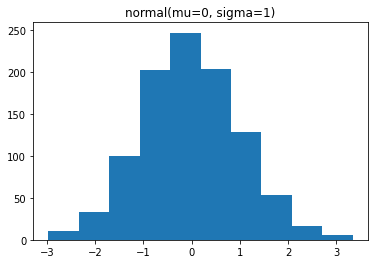

In [62]:
def normal(mu=0, sigma=1, size=1, seed=None):
    """Generates N(mu, sigma) samples using Box-Muller Transform"""
    u1 = rand(seed=seed, size=size)
    u2 = rand(seed=seed+1, size=size)
    z0 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    z1 = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)
    return z0 * sigma + mu

size = 1000
samples = normal(size=size, seed=seed, mu=0, sigma=1)
summarize(samples, title=f'normal(mu=0, sigma=1)')

## References

[1] https://towardsdatascience.com/how-to-generate-random-variables-from-scratch-no-library-used-4b71eb3c8dc7